In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import warnings

warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette("husl")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


device = torch.device('cpu') 

#### 원본 모델 로드

In [2]:
# NCF 모델 클래스 정의
class NCF(nn.Module):
    def __init__(self, n_users, n_games, embedding_dim=64, hidden_layers=[128, 64, 32]):
        super(NCF, self).__init__()
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.game_embedding = nn.Embedding(n_games, embedding_dim)
        
        self.fc_layers = nn.ModuleList()
        input_size = embedding_dim * 2
        
        for hidden_size in hidden_layers:
            self.fc_layers.append(nn.Linear(input_size, hidden_size))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(0.2))
            input_size = hidden_size
        
        self.output = nn.Linear(hidden_layers[-1], 1)
    
    def forward(self, user_ids, game_ids):
        user_emb = self.user_embedding(user_ids)
        game_emb = self.game_embedding(game_ids)
        
        x = torch.cat([user_emb, game_emb], dim=1)
        
        for layer in self.fc_layers:
            x = layer(x)
        
        output = self.output(x)
        return output.squeeze()

# 모델 로드
model_path = Path("../outputs/models/ncf_model.pth")
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

n_users = checkpoint['n_users']
n_games = checkpoint['n_games']
embedding_dim = checkpoint['embedding_dim']
hidden_layers = checkpoint['hidden_layers']

model_fp32 = NCF(n_users, n_games, embedding_dim, hidden_layers)
model_fp32.load_state_dict(checkpoint['model_state_dict'])
model_fp32.eval()

print(f"원본 모델 로드 완료")
print(f"  - 파라미터 수: {sum(p.numel() for p in model_fp32.parameters()):,}")

원본 모델 로드 완료
  - 파라미터 수: 6,806,977


#### 테스트 데이터 준비

In [3]:

data_path = Path("../data")
ratings_df = pd.read_csv(data_path / "user_ratings.csv")

user_counts = ratings_df['Username'].value_counts()
active_users = user_counts[user_counts >= 50].index

game_counts = ratings_df['BGGId'].value_counts()
popular_games = game_counts[game_counts >= 100].index

ratings_filtered = ratings_df[
    (ratings_df['Username'].isin(active_users)) & 
    (ratings_df['BGGId'].isin(popular_games))
].copy()

del ratings_df

user_to_id = checkpoint['user_to_id']
game_to_id = checkpoint['game_to_id']

ratings_filtered['user_id'] = ratings_filtered['Username'].map(user_to_id)
ratings_filtered['game_id'] = ratings_filtered['BGGId'].map(game_to_id)

from sklearn.model_selection import train_test_split
_, test_data = train_test_split(
    ratings_filtered[['user_id', 'game_id', 'Rating']], 
    test_size=0.2, 
    random_state=42
)

print(f"테스트 데이터: {len(test_data):,}행")

# Dataset
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.users = torch.LongTensor(data['user_id'].values)
        self.games = torch.LongTensor(data['game_id'].values)
        self.ratings = torch.FloatTensor(data['Rating'].values)
    
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        return self.users[idx], self.games[idx], self.ratings[idx]

test_dataset = RatingsDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

테스트 데이터: 2,946,792행


#### 원본 모델 평가 (FP32)

In [4]:
def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    actuals = []
    
    start_time = time.time()
    
    with torch.no_grad():
        for user_ids, game_ids, ratings in loader:
            user_ids = user_ids.to(device)
            game_ids = game_ids.to(device)
            
            preds = model(user_ids, game_ids)
            
            predictions.extend(preds.cpu().numpy())
            actuals.extend(ratings.numpy())
    
    inference_time = time.time() - start_time
    
    predictions = np.array(predictions).clip(1, 10)
    actuals = np.array(actuals)
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    
    return rmse, mae, inference_time

rmse_fp32, mae_fp32, time_fp32 = evaluate_model(model_fp32, test_loader, device)

print(f"FP32 모델:")
print(f"  - RMSE: {rmse_fp32:.4f}")
print(f"  - MAE: {mae_fp32:.4f}")
print(f"  - 추론 시간: {time_fp32:.2f}초")

# 모델 크기 계산
def get_model_size(model):
    torch.save(model.state_dict(), 'temp_model.pth')
    size_mb = Path('temp_model.pth').stat().st_size / (1024 * 1024)
    Path('temp_model.pth').unlink()
    return size_mb

size_fp32 = get_model_size(model_fp32)
print(f"  - 모델 크기: {size_fp32:.2f} MB")

FP32 모델:
  - RMSE: 1.1061
  - MAE: 0.8247
  - 추론 시간: 42.60초
  - 모델 크기: 25.97 MB


#### Dynamic Quantization (8-bit)

In [5]:
# Embedding은 제외, Linear만 양자화
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32,
    {nn.Linear},  # Embedding 제외
    dtype=torch.qint8
)
rmse_int8, mae_int8, time_int8 = evaluate_model(model_int8, test_loader, device)

print(f"INT8 모델:")
print(f"  - RMSE: {rmse_int8:.4f}")
print(f"  - MAE: {mae_int8:.4f}")
print(f"  - 추론 시간: {time_int8:.2f}초")

size_int8 = get_model_size(model_int8)
print(f"  - 모델 크기: {size_int8:.2f} MB")

print(f"\nFP32 대비:")
print(f"  - 정확도 손실 (RMSE): {(rmse_int8 - rmse_fp32):.4f}")
print(f"  - 크기 감소: {(1 - size_int8/size_fp32)*100:.1f}%")
print(f"  - 속도 향상: {(time_fp32/time_int8 - 1)*100:.1f}%")

INT8 모델:
  - RMSE: 1.1064
  - MAE: 0.8251
  - 추론 시간: 34.96초
  - 모델 크기: 25.90 MB

FP32 대비:
  - 정확도 손실 (RMSE): 0.0003
  - 크기 감소: 0.3%
  - 속도 향상: 21.9%


#### 개선된 2-bit 양자화

In [6]:
class ImprovedQuantize2bit(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.original_model = original_model
        
        # Embedding weights를 미리 양자화 (per-tensor)
        self.user_emb_q, self.user_emb_scale, self.user_emb_zero = self._quantize_embedding(
            original_model.user_embedding.weight
        )
        self.game_emb_q, self.game_emb_scale, self.game_emb_zero = self._quantize_embedding(
            original_model.game_embedding.weight
        )
    
    def _quantize_embedding(self, weights):
        """Per-tensor 2-bit 양자화 (scale/zero-point 유지)"""
        # Min-max scaling
        min_val = weights.min().item()
        max_val = weights.max().item()
        
        # 4 레벨: 0, 1, 2, 3
        scale = (max_val - min_val) / 3.0
        zero_point = min_val
        
        # 양자화
        quantized = torch.clamp(
            torch.round((weights - zero_point) / scale),
            0, 3
        ).to(torch.uint8)
        
        return quantized, scale, zero_point
    
    def _dequantize(self, quantized, scale, zero_point):
        """역양자화"""
        return quantized.float() * scale + zero_point
    
    def forward(self, user_ids, game_ids):
        # Embedding lookup with dequantization
        user_emb = nn.functional.embedding(
            user_ids, 
            self._dequantize(self.user_emb_q, self.user_emb_scale, self.user_emb_zero)
        )
        game_emb = nn.functional.embedding(
            game_ids,
            self._dequantize(self.game_emb_q, self.game_emb_scale, self.game_emb_zero)
        )
        
        x = torch.cat([user_emb, game_emb], dim=1)
        
        # FC layers (원본 가중치 사용 - Embedding이 주요 크기)
        for layer in self.original_model.fc_layers:
            x = layer(x)
        
        output = self.original_model.output(x)
        return output.squeeze()

model_2bit_improved = ImprovedQuantize2bit(model_fp32)
model_2bit_improved.eval()

print("개선된 2-bit 양자화 완료")
print("  - Embedding만 2-bit 양자화 (전체 파라미터의 약 99%)")
print("  - FC layers는 FP32 유지 (정확도 보존)")

rmse_2bit, mae_2bit, time_2bit = evaluate_model(model_2bit_improved, test_loader, device)

print(f"\n2-bit 모델 (개선):")
print(f"  - RMSE: {rmse_2bit:.4f}")
print(f"  - MAE: {mae_2bit:.4f}")
print(f"  - 추론 시간: {time_2bit:.2f}초")

# 이론적 크기 계산
# User embedding: 93,637 x 64 = 5,992,768 params
# Game embedding: 12,302 x 64 = 787,328 params
# Total embeddings: 6,780,096 params (99.6%)
# FC layers: 26,881 params (0.4%)

embedding_params = n_users * embedding_dim + n_games * embedding_dim
fc_params = sum(p.numel() for p in model_fp32.parameters()) - embedding_params

# FP32: 4 bytes, 2-bit: 0.25 bytes
size_2bit_embedding = (embedding_params * 0.25) / (1024 * 1024)  # MB
size_2bit_fc = (fc_params * 4) / (1024 * 1024)  # MB
size_2bit_total = size_2bit_embedding + size_2bit_fc

print(f"  - 모델 크기 (이론): {size_2bit_total:.2f} MB")
print(f"    ㄴ Embedding (2-bit): {size_2bit_embedding:.2f} MB")
print(f"    ㄴ FC layers (FP32): {size_2bit_fc:.2f} MB")

print(f"\nFP32 대비:")
print(f"  - 정확도 손실 (RMSE): {(rmse_2bit - rmse_fp32):.4f}")
print(f"  - 크기 감소: {(1 - size_2bit_total/size_fp32)*100:.1f}%")

# 기존 변수 업데이트
size_2bit_theoretical = size_2bit_total

개선된 2-bit 양자화 완료
  - Embedding만 2-bit 양자화 (전체 파라미터의 약 99%)
  - FC layers는 FP32 유지 (정확도 보존)

2-bit 모델 (개선):
  - RMSE: 1.3012
  - MAE: 0.9989
  - 추론 시간: 44.36초
  - 모델 크기 (이론): 1.72 MB
    ㄴ Embedding (2-bit): 1.62 MB
    ㄴ FC layers (FP32): 0.10 MB

FP32 대비:
  - 정확도 손실 (RMSE): 0.1951
  - 크기 감소: 93.4%


#### 성능 비교

In [7]:
results = pd.DataFrame({
    'Model': ['FP32 (Original)', 'INT8 (Dynamic)', '2-bit (Simulated)'],
    'RMSE': [rmse_fp32, rmse_int8, rmse_2bit],
    'MAE': [mae_fp32, mae_int8, mae_2bit],
    'Size (MB)': [size_fp32, size_int8, size_2bit_theoretical],
    'Inference Time (s)': [time_fp32, time_int8, time_2bit]
})

print("\n경량화:")
print(results.to_string(index=False))


경량화:
            Model     RMSE      MAE  Size (MB)  Inference Time (s)
  FP32 (Original) 1.106064 0.824669  25.970754           42.601605
   INT8 (Dynamic) 1.106355 0.825067  25.897023           34.956601
2-bit (Simulated) 1.301177 0.998872   1.719044           44.359522


#### 시각화

저장: ..\outputs\figures\07_quantization_comparison.png


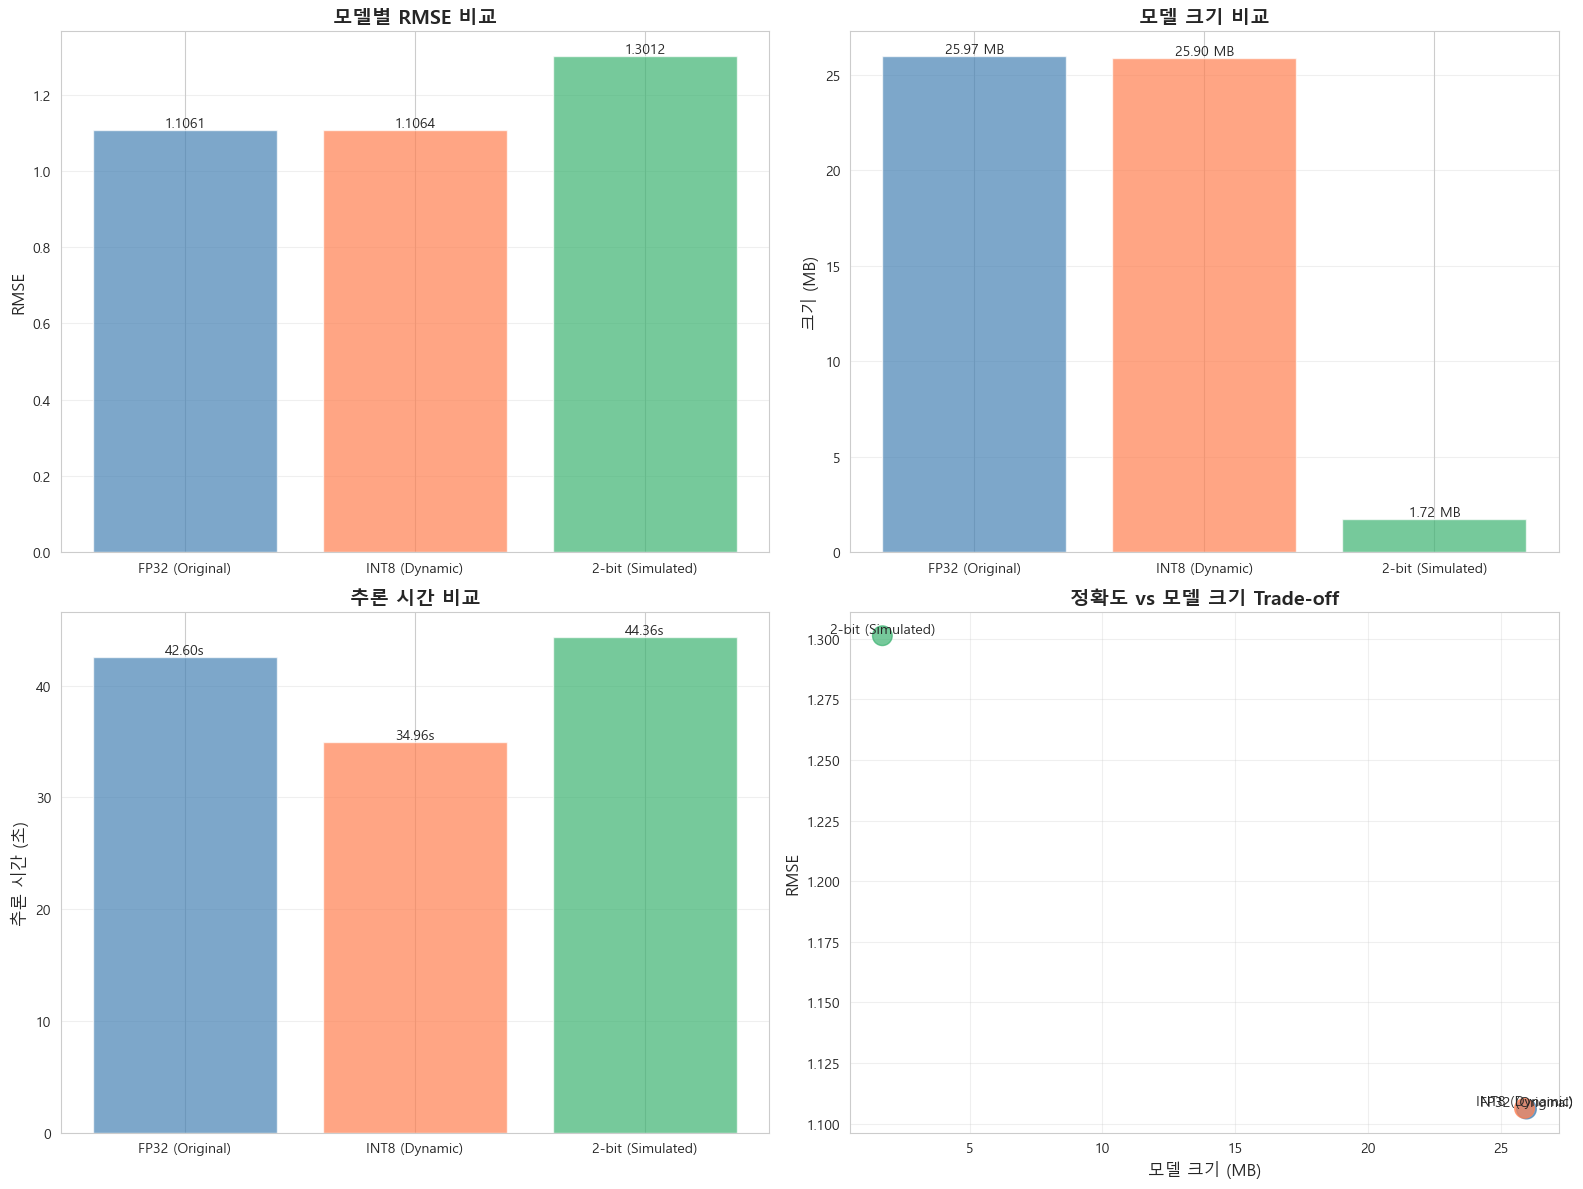

In [8]:
output_path = Path("../outputs/figures")
output_path.mkdir(parents=True, exist_ok=True)

# Figure 1: 성능 비교
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = results['Model']

# RMSE 비교
axes[0, 0].bar(models, results['RMSE'], color=['steelblue', 'coral', 'mediumseagreen'], alpha=0.7)
axes[0, 0].set_ylabel('RMSE', fontsize=12)
axes[0, 0].set_title('모델별 RMSE 비교', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results['RMSE']):
    axes[0, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# 모델 크기 비교
axes[0, 1].bar(models, results['Size (MB)'], color=['steelblue', 'coral', 'mediumseagreen'], alpha=0.7)
axes[0, 1].set_ylabel('크기 (MB)', fontsize=12)
axes[0, 1].set_title('모델 크기 비교', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results['Size (MB)']):
    axes[0, 1].text(i, v, f'{v:.2f} MB', ha='center', va='bottom', fontsize=10)

# 추론 시간 비교
axes[1, 0].bar(models, results['Inference Time (s)'], color=['steelblue', 'coral', 'mediumseagreen'], alpha=0.7)
axes[1, 0].set_ylabel('추론 시간 (초)', fontsize=12)
axes[1, 0].set_title('추론 시간 비교', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results['Inference Time (s)']):
    axes[1, 0].text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=10)

# 정확도-크기 Trade-off
axes[1, 1].scatter(results['Size (MB)'], results['RMSE'], s=200, alpha=0.7, 
                   c=['steelblue', 'coral', 'mediumseagreen'])
for i, model in enumerate(models):
    axes[1, 1].annotate(model, 
                        (results['Size (MB)'].iloc[i], results['RMSE'].iloc[i]),
                        fontsize=10, ha='center', va='bottom')
axes[1, 1].set_xlabel('모델 크기 (MB)', fontsize=12)
axes[1, 1].set_ylabel('RMSE', fontsize=12)
axes[1, 1].set_title('정확도 vs 모델 크기 Trade-off', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_path / '07_quantization_comparison.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '07_quantization_comparison.png'}")
plt.show()
plt.close()

#### 경량화 모델 저장

In [9]:
output_models_path = Path("../outputs/models")

# INT8 모델 
torch.save(model_int8.state_dict(), output_models_path / 'ncf_model_int8.pth')
print(f"저장: {output_models_path / 'ncf_model_int8.pth'}")

results.to_csv(Path("../outputs/reports") / 'quantization_results.csv', index=False)
print(f"저장: ../outputs/reports/quantization_results.csv")

저장: ..\outputs\models\ncf_model_int8.pth
저장: ../outputs/reports/quantization_results.csv


#### summary

In [10]:
print("\n경량화 요약:")
print(f"  FP32 -> INT8:")
print(f"    - 크기 감소: {(1 - size_int8/size_fp32)*100:.1f}%")
print(f"    - RMSE 변화: {rmse_fp32:.4f} -> {rmse_int8:.4f}")
print(f"  FP32 -> 2-bit (이론):")
print(f"    - 크기 감소: {(1 - size_2bit_theoretical/size_fp32)*100:.1f}%")
print(f"    - RMSE 변화: {rmse_fp32:.4f} -> {rmse_2bit:.4f}")

print("\n생성된 파일:")
print(f"   [시각화]")
print(f"   - {output_path / '07_quantization_comparison.png'}")
print(f"   [모델]")
print(f"   - {output_models_path / 'ncf_model_int8.pth'}")
print(f"   [보고서]")
print(f"   - ../outputs/reports/quantization_results.csv")


경량화 요약:
  FP32 -> INT8:
    - 크기 감소: 0.3%
    - RMSE 변화: 1.1061 -> 1.1064
  FP32 -> 2-bit (이론):
    - 크기 감소: 93.4%
    - RMSE 변화: 1.1061 -> 1.3012

생성된 파일:
   [시각화]
   - ..\outputs\figures\07_quantization_comparison.png
   [모델]
   - ..\outputs\models\ncf_model_int8.pth
   [보고서]
   - ../outputs/reports/quantization_results.csv
